<a href="https://www.kaggle.com/code/loananh/lstm-prediction?scriptVersionId=228816302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Prepare Python Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load Dataframe
data = pd.read_csv('/kaggle/input/hose-market/CafeF.HSX.Upto07.03.2025.csv')

# Rename column <DTYYYYMMDD> to Date
data.rename(columns={'<DTYYYYMMDD>': '<Date>'}, inplace=True)

# Convert <DTYYYYMMDD> from number to date format
data['<Date>'] = pd.to_datetime(data['<Date>'], format='%Y%m%d')

# Filter Stock Data for Analytics (SSI Stock in 10 years)
start_date = datetime.now()
end_date = datetime(start_date.year-10, start_date.month, start_date.day)
df = data[(data['<Ticker>']=='SSI') & (data['<Date>'] >= end_date) & (data['<Date>'] <= start_date)]

# Sort date and index in ascending
df = df.iloc[::-1]
df = df.reset_index(drop = True, inplace = False)

print(df)

#Get the duration of data set
print("Starting date: ", df.iloc[0]['<Date>'])
print("Ending date: ", df.iloc[-1]['<Date>'])
print("Duration: ", df.iloc[-1]['<Date>'] - df.iloc[0]['<Date>'])

     <Ticker>     <Date>   <Open>   <High>    <Low>  <Close>  <Volume>
0         SSI 2015-03-23   6.1862   6.3581   6.1862   6.1871   1294430
1         SSI 2015-03-24   6.1576   6.1576   6.0430   6.1012   2563650
2         SSI 2015-03-25   6.1290   6.1576   6.0144   6.0153   1506060
3         SSI 2015-03-26   5.9571   6.0430   5.8998   5.9293   2051060
4         SSI 2015-03-27   5.9571   6.0430   5.8426   5.8434   1652550
...       ...        ...      ...      ...      ...      ...       ...
2484      SSI 2025-03-03  26.3000  26.8000  26.1500  26.6000  25645100
2485      SSI 2025-03-04  26.4500  26.6000  26.1000  26.3500  24072400
2486      SSI 2025-03-05  26.4000  26.6500  26.1000  26.1000  27564200
2487      SSI 2025-03-06  26.2000  26.9500  26.2000  26.9000  44988800
2488      SSI 2025-03-07  27.1000  27.1500  26.8000  26.9000  22896800

[2489 rows x 7 columns]
Starting date:  2015-03-23 00:00:00
Ending date:  2025-03-07 00:00:00
Duration:  3637 days 00:00:00


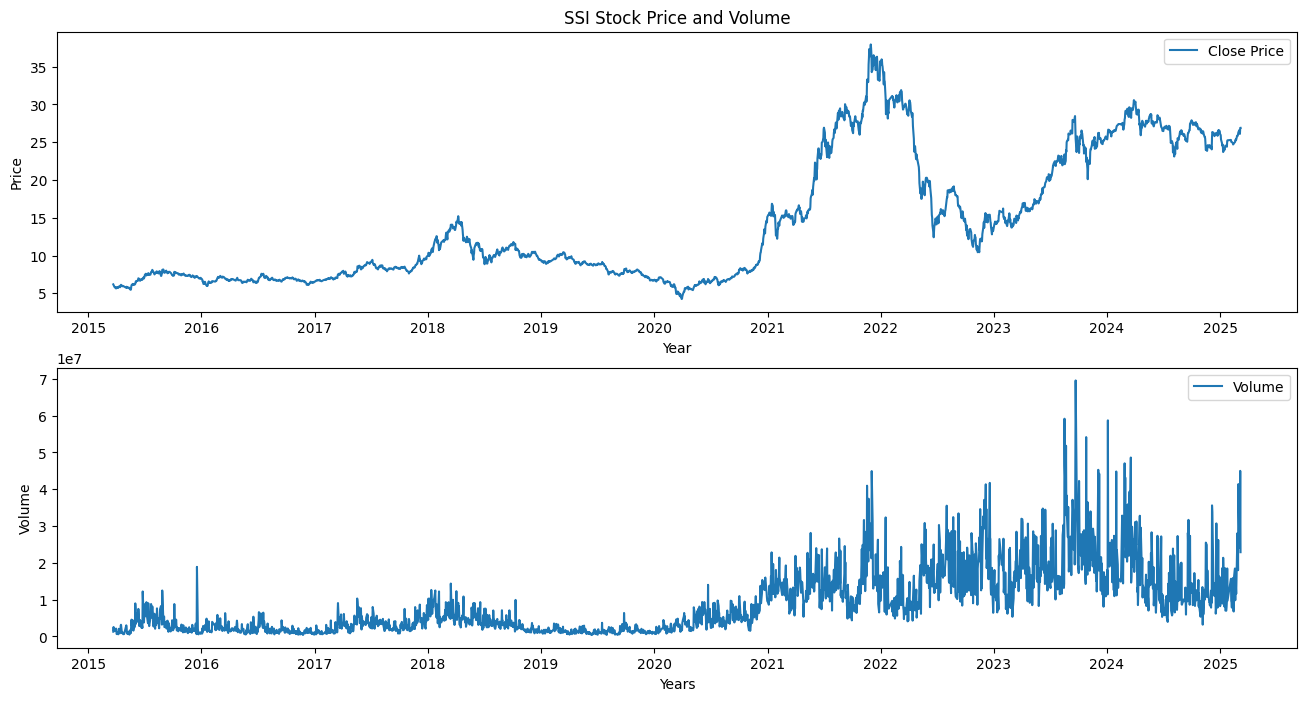

In [2]:
#Plot Stock Price and Volume
plt.figure(figsize=(16,8))

# Stock Price Subplot
plt.subplot(2,1,1)
plt.plot(df['<Date>'], df['<Close>'], label='Close Price')
plt.title('SSI Stock Price and Volume')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()

# Stock Volume Subplot
plt.subplot(2,1,2)
plt.plot(df['<Date>'], df['<Volume>'], label='Volume')
plt.xlabel('Years')
plt.ylabel('Volume')
plt.legend()

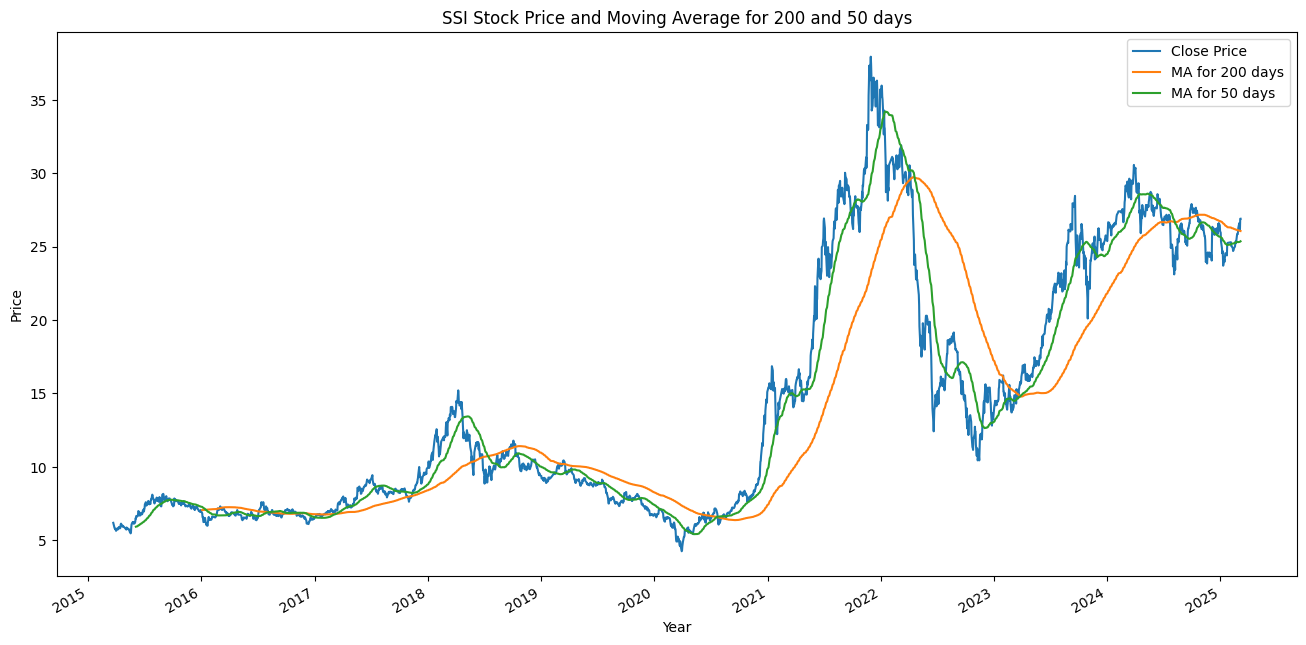

In [3]:
# Calculate Moving Average for 200 days
df['MA for 200 days'] = df['<Close>'].rolling(window=200).mean()
df['MA for 200 days'][0:200].tail()

# Calculate Moving Average for 50 days
df['MA for 50 days'] = df['<Close>'].rolling(window=50).mean()
df['MA for 50 days'][0:50].tail()

# Plot Stock Price and Moving Average
plot_graph = df[['<Date>', '<Close>', 'MA for 200 days', 'MA for 50 days']].plot(x='<Date>', y=['<Close>', 'MA for 200 days', 'MA for 50 days'], figsize=(16,8))
plot_graph.set_title('SSI Stock Price and Moving Average for 200 and 50 days')
plot_graph.set_xlabel('Year')
plot_graph.set_ylabel('Price')
plot_graph.legend(['Close Price', 'MA for 200 days', 'MA for 50 days'])


Daily Return Statistics:
count    2488.000000
mean        0.000866
std         0.023480
min        -0.069973
25%        -0.009854
50%         0.000000
75%         0.011430
max         0.070522
Name: Daily Return, dtype: float64


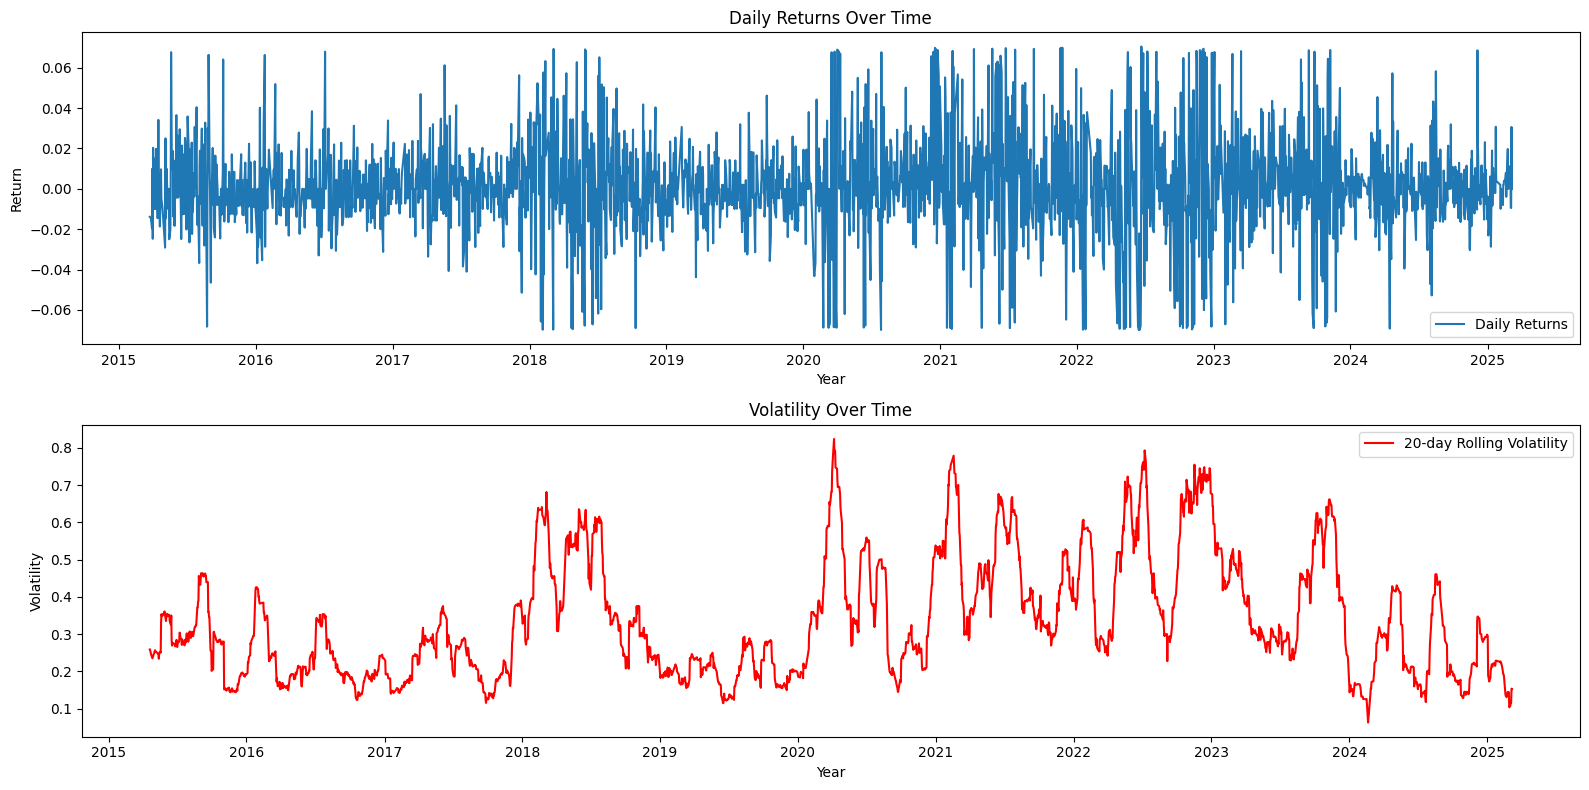


Recent Volatility:
         <Date>  Volatility
2484 2025-03-03    0.108659
2485 2025-03-04    0.116766
2486 2025-03-05    0.116239
2487 2025-03-06    0.153810
2488 2025-03-07    0.153006


In [4]:
# Calculate and analyze Daily Returns
df['Daily Return'] = df['<Close>'].pct_change()

# Statistical Analysis of Daily Returns
print("\nDaily Return Statistics:")
print(df['Daily Return'].describe())

# Calculate Rolling Mean and Standard Deviation
window = 20  # 20-day rolling
df['Rolling Mean'] = df['<Close>'].rolling(window=window).mean()
df['Rolling Std'] = df['<Close>'].rolling(window=window).std()
df['Volatility'] = df['Daily Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized volatility

# Plot Daily Returns and Volatility
plt.figure(figsize=(16, 8))

# Daily Returns subplot
plt.subplot(2, 1, 1)
plt.plot(df['<Date>'], df['Daily Return'], label='Daily Returns')
plt.title('Daily Returns Over Time')
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()

# Volatility subplot
plt.subplot(2, 1, 2)
plt.plot(df['<Date>'], df['Volatility'], label='20-day Rolling Volatility', color='red')
plt.title('Volatility Over Time')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()

plt.tight_layout()
plt.show()

# Print recent volatility
print("\nRecent Volatility:")
print(df[['<Date>', 'Volatility']].tail())

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0399 - val_loss: 0.0036
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0012 - val_l

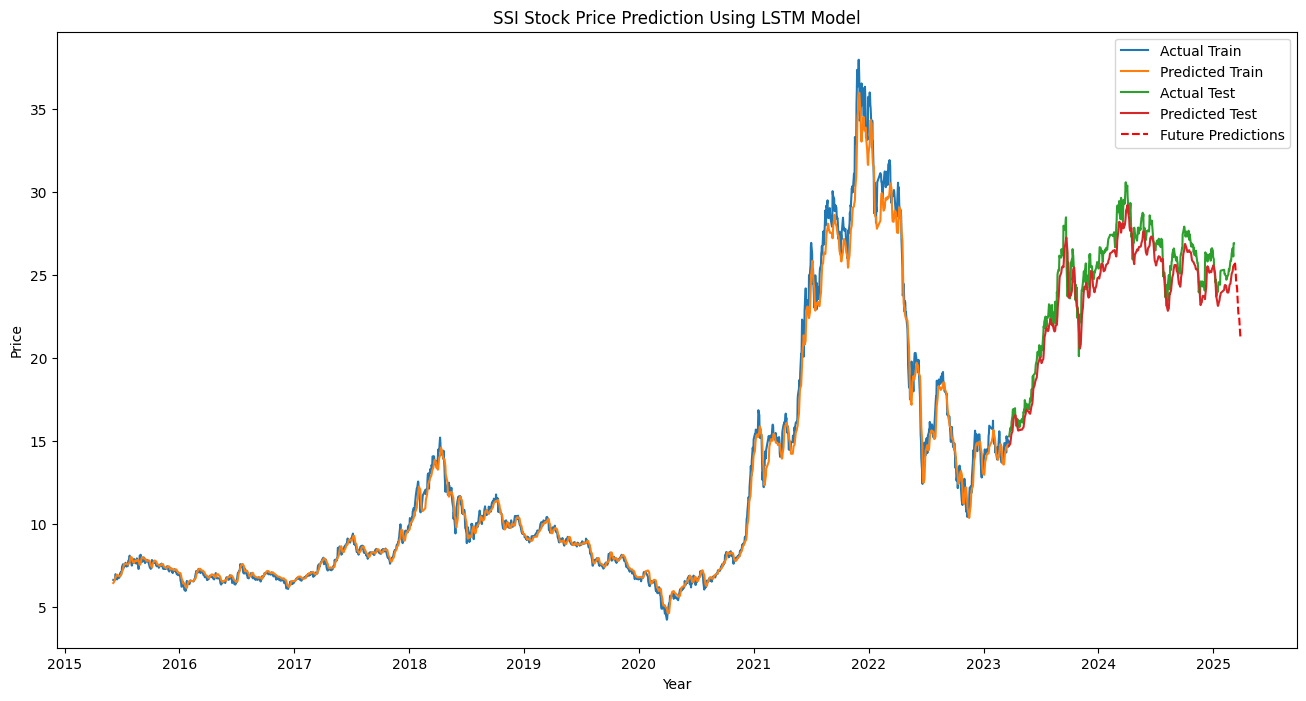

Shapes:
train_dates: (1951,)
train_predict: (1951, 1)
test_dates: (488,)
test_predict: (488, 1)

Future price predictions for the next 15 days:
2025-03-10: 25.72
2025-03-11: 25.59
2025-03-12: 25.32
2025-03-13: 24.97
2025-03-14: 24.59
2025-03-17: 24.19
2025-03-18: 23.80
2025-03-19: 23.42
2025-03-20: 23.05
2025-03-21: 22.69
2025-03-24: 22.35
2025-03-25: 22.02
2025-03-26: 21.70
2025-03-27: 21.39
2025-03-28: 21.09


In [5]:
# Import additional libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import math

# Prepare the data for LSTM
# Select only the closing price
data = df['<Close>'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for training
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (number of time steps)
seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Reshape input data for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split into train and test sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compile with specific learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with try-except block
try:
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
except ValueError as e:
    print(f"Error during training: {e}")
    print(f"Input shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Function to predict future values
def predict_future(model, last_sequence, n_future):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_future):
        # Get prediction for next day
        current_prediction = model.predict(current_sequence.reshape(1, seq_length, 1))
        future_predictions.append(current_prediction[0,0])
        
        # Update sequence by removing first element and adding the prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = current_prediction
        
    return np.array(future_predictions)

# Get the last sequence from our data
last_sequence = scaled_data[-seq_length:]

# Function to generate business dates (excluding weekends)
def get_business_dates(start_date, n_days):
    business_dates = []
    current_date = start_date
    while len(business_dates) < n_days:
        current_date = current_date + pd.Timedelta(days=1)
        if current_date.weekday() < 5:  # Monday = 0, Friday = 4
            business_dates.append(current_date)
    return pd.DatetimeIndex(business_dates)

# Predict next 15 days
n_future = 15
future_predictions = predict_future(model, last_sequence, n_future)

# Scale back to original price
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Generate future business dates (excluding weekends)
last_date = df['<Date>'].iloc[-1]
future_dates = get_business_dates(last_date, n_future)

# Plotting results
plt.figure(figsize=(16,8))

# Calculate correct date ranges
train_dates = df['<Date>'].values[seq_length:len(train_predict)+seq_length]
test_dates = df['<Date>'].values[len(train_predict)+seq_length:len(train_predict)+len(test_predict)+seq_length]

# Plot with aligned dimensions
plt.plot(train_dates, y_train_inv, label='Actual Train')
plt.plot(train_dates, train_predict, label='Predicted Train')
plt.plot(test_dates, y_test_inv, label='Actual Test')
plt.plot(test_dates, test_predict, label='Predicted Test')
plt.plot(future_dates, future_predictions, 'r--', label='Future Predictions')
plt.title('SSI Stock Price Prediction Using LSTM Model')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print shapes for verification
print("Shapes:")
print(f"train_dates: {train_dates.shape}")
print(f"train_predict: {train_predict.shape}")
print(f"test_dates: {test_dates.shape}")
print(f"test_predict: {test_predict.shape}")

# Print future predictions
print("\nFuture price predictions for the next 15 days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]:.2f}")